# Intra session metrics
In order to study intra-session metrics, we first need to create sessions out of visits.
## Visit to Session


### Setup

In [1]:
import glob
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import pyarrow.feather as feather
import seaborn as sns

%matplotlib inline

In [2]:
FEATHER_PATH = "../../data/2019-Oct.feather"
np.random.seed(101)

In [3]:
TIME_DIFF = 60 * 30 # 30 mins # This will decide the maximum time difference between visits belonging to the same session.

In [4]:
%%time
data = feather.read_feather(FEATHER_PATH)

CPU times: user 11.1 s, sys: 3.11 s, total: 14.2 s
Wall time: 12.6 s


### Filtering
We'll randomly sample a small subset of users in order to speed up analysis. 

In [5]:
print("Total number of users:",len(data['user_id'].unique()))

sampled_users = np.random.choice(data['user_id'].unique(), size=10000, replace=False)

Total number of users: 3022290


Deleting the following cell should not break the rest of the code, although things would run much slower.

In [6]:
data = data[data['user_id'].isin(sampled_users)]
print("Total number of users:",len(data['user_id'].unique()))

Total number of users: 10000


In order to stick to the definitions of the source material, let's rename the 'user_session' field to 'visit_id'.

In [7]:
data.rename(columns = {"user_session":"visit_id"}, inplace=True)

### Creating Sessions out of visits
#### Creating a visits table
Let's define a session to be a group of visits that are no more than TIME_DIFF seconds apart. First, let's get the start and end times of each session.

In [8]:
grouped = data.groupby('visit_id')
visits = pd.DataFrame(
    data = [
        grouped['user_id'].min() # max also fine
        ,grouped['event_type'].min() # max also fine
        ,grouped['event_time'].min()
        ,grouped['event_time'].max()
    ]
    ,index = [
        "user_id"
        ,"event_type"
        ,"start_time"
        ,"end_time"
    ]
).T
del grouped
visits.head()

,user_id,event_type,start_time,end_time
visit_id,,,,
0004877e-8ef5-4ffd-90bf-d293b9973991,513325471,view,2019-10-01 05:29:03 UTC,2019-10-01 05:29:03 UTC
000bf4a0-654a-45a0-853f-eeae0df45d26,536331032,view,2019-10-06 17:05:12 UTC,2019-10-06 17:06:32 UTC
000eb398-bae9-43a2-a244-8753155ef1f1,519491226,view,2019-10-31 08:53:21 UTC,2019-10-31 08:53:21 UTC
00103afe-d940-42d8-be96-d1fdab2a4c53,556517838,view,2019-10-06 20:04:02 UTC,2019-10-06 20:04:02 UTC
00118c0a-8c6d-483c-84e5-1ca82e173513,518652214,view,2019-10-13 19:55:15 UTC,2019-10-13 20:30:38 UTC


In [9]:
visits['start_time'] = visits['start_time'].apply(pd.to_datetime)
visits['end_time'] = visits['end_time'].apply(pd.to_datetime)
visits['duration'] = (visits['end_time'] - visits['start_time']).dt.seconds

### From visit to session

In [10]:
%%time

next_visit = {}
time_to_next_visit = {}

for index, row in visits.iterrows():
    future_visits = visits[(visits['user_id']==row['user_id']) & (visits['start_time']>=row['end_time']) & (visits['start_time']>row['start_time'])]
    if len(future_visits) == 0:
            next_visit[index] = np.nan 
            time_to_next_visit[index] = np.nan 
    else:
        next_visit[index] = (future_visits['start_time']-row['end_time']).dt.seconds.idxmin() 
        time_to_next_visit[index] = (future_visits.loc[next_visit[index]]['start_time']-row['end_time']).seconds 

CPU times: user 1min 32s, sys: 329 ms, total: 1min 32s
Wall time: 1min 32s


In [11]:
visits['next_visit_id'] = visits.index.map(next_visit)
visits['time_to_next_visit'] = visits.index.map(time_to_next_visit)
visits.head()

,user_id,event_type,start_time,end_time,duration,next_visit_id,time_to_next_visit
visit_id,,,,,,,
0004877e-8ef5-4ffd-90bf-d293b9973991,513325471,view,2019-10-01 05:29:03+00:00,2019-10-01 05:29:03+00:00,0,865de13b-c0ec-4d9b-9ceb-92e7818dbe1f,1900.0
000bf4a0-654a-45a0-853f-eeae0df45d26,536331032,view,2019-10-06 17:05:12+00:00,2019-10-06 17:06:32+00:00,80,2a349a74-5a33-4bc5-9199-eb184e366389,1799.0
000eb398-bae9-43a2-a244-8753155ef1f1,519491226,view,2019-10-31 08:53:21+00:00,2019-10-31 08:53:21+00:00,0,NaN,NaN
00103afe-d940-42d8-be96-d1fdab2a4c53,556517838,view,2019-10-06 20:04:02+00:00,2019-10-06 20:04:02+00:00,0,NaN,NaN
00118c0a-8c6d-483c-84e5-1ca82e173513,518652214,view,2019-10-13 19:55:15+00:00,2019-10-13 20:30:38+00:00,2123,97ce1822-fda7-4661-867f-30e4a0eb2bd6,40592.0


In [12]:
# %%time

last_visit_in_sessions = {} # key: any visit id; value: the last visit id of the corresponding session

for index, row in visits.iterrows():
    current_index = index
    current_row = row
    session = []

    while current_row['time_to_next_visit'] < TIME_DIFF:
        if current_index in last_visit_in_sessions:
            break
        session.append(current_index)

        current_index = current_row['next_visit_id']
        current_row = visits.loc[current_index]

    session.append(current_index)
    last_visit_in_sessions.update(dict.fromkeys(session, last_visit_in_sessions.get(current_index, current_index)))


In [13]:
visits['last_visit_in_session'] = visits.index.map(last_visit_in_sessions)
visits.head()


,user_id,event_type,start_time,end_time,duration,next_visit_id,time_to_next_visit,last_visit_in_session
visit_id,,,,,,,,
0004877e-8ef5-4ffd-90bf-d293b9973991,513325471,view,2019-10-01 05:29:03+00:00,2019-10-01 05:29:03+00:00,0,865de13b-c0ec-4d9b-9ceb-92e7818dbe1f,1900.0,0004877e-8ef5-4ffd-90bf-d293b9973991
000bf4a0-654a-45a0-853f-eeae0df45d26,536331032,view,2019-10-06 17:05:12+00:00,2019-10-06 17:06:32+00:00,80,2a349a74-5a33-4bc5-9199-eb184e366389,1799.0,517ca520-068e-4855-ab69-489aed0b84dd
000eb398-bae9-43a2-a244-8753155ef1f1,519491226,view,2019-10-31 08:53:21+00:00,2019-10-31 08:53:21+00:00,0,NaN,NaN,000eb398-bae9-43a2-a244-8753155ef1f1
00103afe-d940-42d8-be96-d1fdab2a4c53,556517838,view,2019-10-06 20:04:02+00:00,2019-10-06 20:04:02+00:00,0,NaN,NaN,00103afe-d940-42d8-be96-d1fdab2a4c53
00118c0a-8c6d-483c-84e5-1ca82e173513,518652214,view,2019-10-13 19:55:15+00:00,2019-10-13 20:30:38+00:00,2123,97ce1822-fda7-4661-867f-30e4a0eb2bd6,40592.0,00118c0a-8c6d-483c-84e5-1ca82e173513


In [14]:
grouped = visits.reset_index().groupby('last_visit_in_session')
sessions = pd.concat(
    [
        grouped['user_id'].min().to_frame() # max also fine
        ,grouped['start_time'].min().to_frame()
        ,grouped['end_time'].max().to_frame()
        ,grouped['visit_id'].count()
    ]
    ,axis=1
)
sessions.rename({"visit_id":"visit_id_count"}, axis="columns", inplace=True)
sessions['duration'] = (sessions['end_time'] - sessions['start_time']).dt.seconds
del grouped
sessions.head()

,user_id,start_time,end_time,visit_id_count,duration
last_visit_in_session,,,,,
0004877e-8ef5-4ffd-90bf-d293b9973991,513325471,2019-10-01 05:29:03+00:00,2019-10-01 05:29:03+00:00,1,0
000eb398-bae9-43a2-a244-8753155ef1f1,519491226,2019-10-31 08:53:21+00:00,2019-10-31 08:53:21+00:00,1,0
00103afe-d940-42d8-be96-d1fdab2a4c53,556517838,2019-10-06 20:04:02+00:00,2019-10-06 20:04:02+00:00,1,0
00118c0a-8c6d-483c-84e5-1ca82e173513,518652214,2019-10-13 19:55:15+00:00,2019-10-13 20:30:38+00:00,1,2123
00140e7d-0932-41b0-833c-5d41c67f39a1,560827740,2019-10-28 12:37:38+00:00,2019-10-28 12:37:38+00:00,1,0


# Intra-session metrics

## Downstream Engagement
What does the user do after clicking (viewing) an item. Also related to conversion rate metrics.

In [19]:
print(
f"Fraction of viewed items which were carted:{len(visits[visits['event_type']=='cart']) / len(visits[visits['event_type']=='view']):.4f}" 
)

Fraction of clicked items which were carted:0.0695


In [26]:
print(
f"Fraction of viewed items which were purchased:{len(visits[visits['event_type']=='purchase']) / len(visits[visits['event_type']=='view']):.4f}" 
)

Fraction of clicked items which were purchased:0.0425


## Dwell time
To calculate the right dwell time, rather than getting the duration of the session, one would need to sum the duration of each visit that makes up a session.

In [20]:
visit_from_session = {x:[] for x in last_visit_in_sessions.values()}
for key, value in last_visit_in_sessions.items():
    visit_from_session[value].append(key)

In [21]:
session_dwell_times = {key: visits.loc[value,'duration'].sum() for key,value in last_visit_in_sessions.items()}

In [22]:
sessions['dwell_time'] = sessions.index.map(session_dwell_times)

In [23]:
sessions.head()

,user_id,start_time,end_time,visit_id_count,duration,dwell_time
last_visit_in_session,,,,,,
0004877e-8ef5-4ffd-90bf-d293b9973991,513325471,2019-10-01 05:29:03+00:00,2019-10-01 05:29:03+00:00,1,0,0
000eb398-bae9-43a2-a244-8753155ef1f1,519491226,2019-10-31 08:53:21+00:00,2019-10-31 08:53:21+00:00,1,0,0
00103afe-d940-42d8-be96-d1fdab2a4c53,556517838,2019-10-06 20:04:02+00:00,2019-10-06 20:04:02+00:00,1,0,0
00118c0a-8c6d-483c-84e5-1ca82e173513,518652214,2019-10-13 19:55:15+00:00,2019-10-13 20:30:38+00:00,1,2123,2123
00140e7d-0932-41b0-833c-5d41c67f39a1,560827740,2019-10-28 12:37:38+00:00,2019-10-28 12:37:38+00:00,1,0,0


In [24]:
print("Describing the duration in seconds, we get:")
round(sessions['dwell_time'].describe())

Describing the duration in seconds, we get:


count    22942.0
mean       469.0
std       3284.0
min          0.0
25%          0.0
50%         63.0
75%        265.0
max      85352.0
Name: dwell_time, dtype: float64

Therefore, we can say a user spends about a minute when engaging with the app.

## Revisits

### Revisit rate

In [28]:
print(f"Fraction of sessions with more than one visit (revisit rate): {len(sessions[sessions['visit_id_count']>1]) / len(sessions):.4f}")

Fraction of sessions with more than one visit (revisit rate): 0.1951


### Average time between visits

In [32]:
time_between_visits = (sessions[sessions['visit_id_count']>1]['duration'] - sessions[sessions['visit_id_count']>1]['dwell_time']) / (sessions[sessions['visit_id_count']>1]['visit_id_count'] - 1)

In [33]:
time_between_visits.describe()

count     4476.000000
mean       749.547869
std        855.465551
min          0.000000
25%        205.750000
50%        515.750000
75%       1040.625000
max      14895.000000
dtype: float64

Taking the median, we see that users spend about eight and a half minutes between visits in the same session.

### Pageview
In our case, it would be the items that were viewed in the session. Since each visit seems to correspond with a single item id, we simply need to count the number of visits in each session.

In [27]:
print("Looking at the number of visits each session, we get:")
round(sessions['visit_id_count'].describe())

Looking at the number of visits each session, we get:


count    22942.0
mean         1.0
std          1.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max         35.0
Name: visit_id_count, dtype: float64

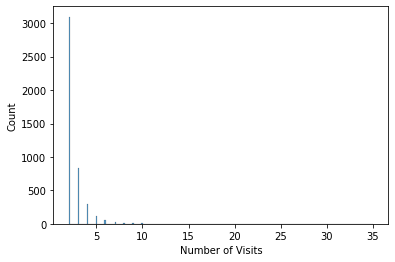

In [29]:
sns.histplot(sessions[sessions['visit_id_count']>1]['visit_id_count'])
plt.xlabel('Number of Visits')
plt.show()